In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install surprise

In [3]:
import os
import numpy as np
import pandas as pd

# 1. Popularity Based Recommendation System

## About the Dataset (jokes.csv)



 
1. Ratings are real values ranging from -10.00 to +10.00 (the value "99" corresponds to "null" = "not rated").
  
2. One row per user
3. The first column gives the number of jokes rated by that user. The next 100 columns give the ratings for jokes 01 - 100.



### Q1. Read the data (jokes.csv)

In [4]:
j_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Great_Learning/Lab_ML/R-5:LAB_Session:Recommendation_System/jokes.csv")

In [5]:
j_df.sample(10)

,NumJokes,Joke1,Joke2,Joke3,Joke4,Joke5,Joke6,Joke7,Joke8,Joke9,Joke10,Joke11,Joke12,Joke13,Joke14,Joke15,Joke16,Joke17,Joke18,Joke19,Joke20,Joke21,Joke22,Joke23,Joke24,Joke25,Joke26,Joke27,Joke28,Joke29,Joke30,Joke31,Joke32,Joke33,Joke34,Joke35,Joke36,Joke37,Joke38,Joke39,...,Joke61,Joke62,Joke63,Joke64,Joke65,Joke66,Joke67,Joke68,Joke69,Joke70,Joke71,Joke72,Joke73,Joke74,Joke75,Joke76,Joke77,Joke78,Joke79,Joke80,Joke81,Joke82,Joke83,Joke84,Joke85,Joke86,Joke87,Joke88,Joke89,Joke90,Joke91,Joke92,Joke93,Joke94,Joke95,Joke96,Joke97,Joke98,Joke99,Joke100
13871,97,0.53,5.97,8.74,-9.22,0.92,1.41,-7.28,1.21,-9.22,9.27,5.10,-6.84,-1.89,5.78,1.07,-3.69,-0.97,-1.50,-7.82,-7.38,4.66,1.89,-2.82,7.57,1.36,3.16,3.06,-8.88,6.75,-6.65,-9.76,9.13,-8.79,5.34,3.20,3.11,-9.22,5.78,1.80,...,-3.01,6.89,-2.72,-9.32,8.40,-8.01,4.42,5.92,3.93,8.40,-5.87,99.00,99.00,99.00,-9.37,7.48,6.70,6.70,6.70,6.70,6.70,6.70,6.70,6.70,6.70,6.94,7.28,7.33,7.33,7.33,7.33,7.38,7.48,7.48,-6.70,7.72,7.72,7.72,7.72,8.11
13833,100,-0.05,4.37,-6.36,-6.26,-6.94,-5.87,-0.53,-7.91,4.71,6.99,4.47,-6.70,3.69,-2.14,4.27,-6.31,3.64,-5.53,-5.87,-5.00,6.70,-5.97,-5.15,-5.58,-6.21,-0.49,2.91,-5.34,3.59,-7.57,7.04,2.43,-7.57,-5.58,7.43,4.61,-4.17,-6.84,4.17,...,0.53,3.79,-5.24,-3.98,6.50,0.68,-4.66,4.37,0.53,-7.72,-7.43,-4.37,-6.99,-8.30,-7.57,5.97,-6.60,-7.23,-3.98,-5.97,-6.55,-7.48,3.11,-7.82,5.97,6.26,-7.96,-5.97,7.38,3.98,-6.89,-7.23,-7.67,6.89,-4.08,-1.36,0.97,0.34,3.69,6.41
20831,74,8.64,-9.61,-6.60,-0.39,-0.29,-0.34,5.24,-4.37,3.20,9.37,8.74,-5.15,-0.83,-5.00,4.13,5.92,0.87,6.36,-5.78,-4.47,4.95,4.56,5.87,0.15,9.22,-3.59,7.67,-1.12,6.84,-3.50,4.32,4.37,-4.22,-5.19,3.11,5.19,6.41,3.11,2.57,...,3.16,8.35,-2.38,-0.92,6.55,6.99,-3.54,5.05,6.17,-2.57,99.00,99.00,-1.36,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,-6.75,99.00,99.00,-3.79,99.00,99.00,3.88,99.00,99.00
17040,100,5.15,2.96,5.83,-7.14,-9.08,8.01,3.74,3.64,-4.76,3.45,0.87,-7.23,-8.98,0.92,5.68,-9.08,-5.73,1.07,0.87,-6.65,1.07,-2.14,-6.70,5.97,3.45,-0.29,-6.36,3.06,-6.31,-6.65,6.12,6.31,2.96,-8.54,-6.46,3.11,-4.03,-6.21,-2.28,...,5.10,3.16,-3.93,-1.55,-8.50,0.63,-7.14,7.77,5.05,-4.32,2.52,1.26,3.11,0.49,2.72,5.49,1.02,1.21,-6.50,3.16,-6.21,4.03,1.31,-3.93,5.15,5.29,3.79,3.11,5.97,5.44,3.64,0.34,3.59,8.06,2.82,3.45,3.35,2.38,-6.60,5.58
4504,71,8.11,8.01,7.04,6.94,5.00,7.48,-8.54,-1.75,7.82,6.99,7.91,6.99,0.15,5.78,4.42,-6.36,-0.97,-5.92,-6.55,-6.17,7.38,6.99,7.77,8.06,6.99,8.93,7.57,7.96,6.02,-6.46,7.57,8.06,-8.54,8.01,8.54,6.36,7.28,6.99,6.99,...,7.52,7.33,8.25,-6.65,6.36,7.72,-9.13,7.04,7.62,8.83,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,7.43,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00
24694,71,1.94,-6.89,-2.82,1.75,3.16,1.07,6.50,-7.82,-3.30,-3.79,2.33,-1.99,-6.80,2.67,-7.04,2.04,1.80,2.09,3.69,-2.18,-2.48,1.80,-6.41,1.70,1.46,-1.99,7.14,-6.41,-6.70,-2.38,1.46,2.09,-3.35,2.09,1.84,7.72,-2.09,-6.46,-2.77,...,7.91,-6.12,-3.54,-3.69,1.12,-6.02,1.50,2.18,-8.40,-3.45,99.00,99.00,99.00,99.00,99.00,99.00,2.96,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00
18828,39,99.00,99.00,99.00,99.00,-2.62,99.00,-4.27,-5.97,99.00,99.00,99.00,-3.30,3.40,-4.22,-4.13,-7.48,-0.68,-3.50,-4.51,-4.17,-3.88,99.00,99.00,99.00,99.00,1.55,3.01,-3.79,-4.03,99.00,1.41,-3.06,99.00,99.00,-0.34,-2.09,99.00,-5.19,99.00,...,1.17,1.99,99.00,99.00,0.97,-1.70,-3.69,1.60,1.26,-3.98,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00
235,70,-9.90,3.50,6.89,-4.90,3.69,7.77,4.81,-0.05,5.34,7.82,9.37,9.37,-1.02,7.33,2.96,-8.69,-0.63,-0.87,2.18,2.57,7.14,7.96,8.40,5.44,6.75,9.27,5.63,1.60,8.93,6.84,7.86,4.27,-6.21,8.64,9.27,8.93,4.37,7.28,4.42,...,6.41,6.65,4.85,-8.74,9.32,3.83,7.23,7.09,9.27,9.32,99.00

In [6]:
j_df.shape

(24983, 101)

### Q2. Create new Dataframe `ratings` starting from column `joke1` and consider first 200 rows only



In [7]:
ratings = j_df.iloc[0:200, 1:]
ratings.head(5)

,Joke1,Joke2,Joke3,Joke4,Joke5,Joke6,Joke7,Joke8,Joke9,Joke10,Joke11,Joke12,Joke13,Joke14,Joke15,Joke16,Joke17,Joke18,Joke19,Joke20,Joke21,Joke22,Joke23,Joke24,Joke25,Joke26,Joke27,Joke28,Joke29,Joke30,Joke31,Joke32,Joke33,Joke34,Joke35,Joke36,Joke37,Joke38,Joke39,Joke40,...,Joke61,Joke62,Joke63,Joke64,Joke65,Joke66,Joke67,Joke68,Joke69,Joke70,Joke71,Joke72,Joke73,Joke74,Joke75,Joke76,Joke77,Joke78,Joke79,Joke80,Joke81,Joke82,Joke83,Joke84,Joke85,Joke86,Joke87,Joke88,Joke89,Joke90,Joke91,Joke92,Joke93,Joke94,Joke95,Joke96,Joke97,Joke98,Joke99,Joke100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,-8.50,-6.75,-7.18,8.45,-7.18,-7.52,-7.43,-9.81,-9.85,-9.85,-9.37,1.50,-4.37,-9.81,-8.50,1.12,7.82,2.86,9.13,-7.43,2.14,-4.08,-9.08,7.82,5.05,4.95,-9.17,-8.40,-8.40,-8.40,...,8.59,3.59,-6.84,-9.03,2.82,-1.36,-9.08,8.30,5.68,-4.81,99.0,99.00,99.0,99.00,99.00,99.00,99.00,-9.42,99.00,99.00,99.00,-7.72,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,6.75,8.64,4.42,7.43,4.56,-0.97,4.66,-0.68,3.30,-1.21,0.87,8.64,8.35,9.17,0.05,7.57,4.71,0.87,-0.39,6.99,6.50,-0.92,7.14,9.03,-1.80,0.73,7.09,3.40,-0.87,7.91,...,-6.70,-3.35,-9.03,4.47,4.08,-3.83,8.74,1.12,0.78,7.52,-5.0,2.77,8.3,7.77,7.33,6.21,7.72,8.98,8.64,8.20,3.93,4.85,4.85,6.07,8.98,4.51,-0.05,3.69,4.56,0.58,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,7.33,7.57,9.37,6.17,-6.36,-6.89,-7.86,9.03,9.03,9.03,7.28,99.00,8.25,99.00,99.00,7.48,7.28,7.28,8.93,99.00,6.17,7.28,99.00,99.00,8.98,7.33,99.00,6.17,9.08,7.33,...,6.46,7.28,99.00,99.00,7.04,7.28,99.00,7.28,8.25,99.00,99.0,99.00,99.0,99.00,99.00,8.93,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,9.03,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,7.33,6.60,6.31,8.11,-7.23,-6.65,1.17,-6.60,-3.64,-2.09,5.34,99.00,99.00,99.00,99.00,2.91,3.93,6.75,6.60,99.00,6.65,-6.12,99.00,7.57,6.21,6.65,99.00,-8.30,7.18,2.82,...,0.00,-3.69,99.00,99.00,7.82,0.24,99.00,7.28,-2.33,99.00,99.0,99.00,99.0,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,99.00,0.63,99.00,99.00,-2.33,99.00,99.00,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,8.25,6.84,-3.93,7.23,-2.33,-9.66,2.72,-1.36,2.57,4.51,8.20,6.12,8.30,-1.26,7.77,1.89,-1.17,5.68,8.45,4.61,8.06,-9.47,7.28,5.68,2.48,3.20,-1.26,6.80,4.51,2.48,...,7.38,6.17,4.71,-2.28,7.38,4.56,7.14,4.22,3.01,3.83,99.0,99.00,99.0,99.00,99.00,99.00,4.13,99.00,99.00,99.00,5.24,5.92,0.87,7.28,3.93,-0.63,6.31,4.71,2.82,2.96,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [8]:
ratings.shape

(200, 100)

### Q3. Preprocess `ratings`


*   Verify presence of null values
*   Replace null with 0



In [9]:
ratings.isnull().sum().sum()

0

In [10]:
ratings.replace(99,0, inplace=True)

In [11]:
ratings.tail()

,Joke1,Joke2,Joke3,Joke4,Joke5,Joke6,Joke7,Joke8,Joke9,Joke10,Joke11,Joke12,Joke13,Joke14,Joke15,Joke16,Joke17,Joke18,Joke19,Joke20,Joke21,Joke22,Joke23,Joke24,Joke25,Joke26,Joke27,Joke28,Joke29,Joke30,Joke31,Joke32,Joke33,Joke34,Joke35,Joke36,Joke37,Joke38,Joke39,Joke40,...,Joke61,Joke62,Joke63,Joke64,Joke65,Joke66,Joke67,Joke68,Joke69,Joke70,Joke71,Joke72,Joke73,Joke74,Joke75,Joke76,Joke77,Joke78,Joke79,Joke80,Joke81,Joke82,Joke83,Joke84,Joke85,Joke86,Joke87,Joke88,Joke89,Joke90,Joke91,Joke92,Joke93,Joke94,Joke95,Joke96,Joke97,Joke98,Joke99,Joke100
195,5.73,0.00,-0.58,1.75,2.86,7.23,2.04,-4.27,3.11,7.14,1.17,7.38,1.21,-0.58,1.02,-0.15,-2.43,2.86,0.78,2.96,3.93,0.44,0.78,-1.75,0.29,1.75,6.89,3.40,3.35,0.53,6.41,5.68,3.93,-0.10,6.55,6.41,0.29,6.55,2.67,3.98,...,5.44,5.78,7.57,-1.70,4.81,6.46,-0.15,7.04,7.52,0.87,-0.19,3.88,0.05,0.97,-0.34,4.61,0.10,0.49,-2.62,-0.49,-2.96,5.44,5.73,2.43,2.14,3.98,4.66,-2.14,4.08,1.46,1.70,4.66,1.65,5.58,5.73,3.50,0.00,-2.04,2.91,1.84
196,1.80,5.39,8.06,-0.10,4.81,4.66,-7.09,-7.72,3.69,4.47,-0.15,4.71,-7.18,-0.68,-0.34,-5.68,-1.36,1.84,4.51,-0.19,4.81,4.51,4.56,-0.10,6.46,-0.10,7.04,-0.10,3.98,1.70,-0.97,2.48,1.12,6.36,4.22,-0.15,-0.73,-2.57,4.66,5.34,...,1.89,2.52,4.27,-0.15,3.45,8.30,5.87,4.71,6.21,5.68,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.73,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
197,2.62,-3.79,-1.17,-0.44,-1.02,5.05,-3.69,2.18,3.30,-0.73,2.18,1.55,-1.46,-3.30,-3.11,5.58,-2.28,-4.03,-1.89,-2.14,-0.68,-2.62,0.10,-3.35,-3.11,-0.24,2.14,-1.07,2.33,-3.01,2.57,-1.50,-4.27,-3.45,-3.35,-3.01,-3.98,2.86,2.48,-1.50,...,2.33,2.04,-2.33,-1.75,1.65,3.40,2.77,2.09,3.35,-2.04,-1.41,3.74,-3.64,-1.07,-3.20,0.15,-1.65,-2.04,-1.02,-3.40,-3.06,-4.42,4.71,-1.65,-4.56,-4.37,-0.34,-3.40,1.17,-4.08,1.41,-2.52,-0.53,-1.89,1.17,-2.04,-1.17,-0.73,0.73,0.44
198,0.00,0.00,0.00,0.00,7.91,0.00,3.64,-1.89,0.00,0.00,0.00,0.00,-2.86,3.45,2.57,-2.48,1.17,4.81,-2.23,-8.30,8.98,0.00,0.00,0.00,2.96,4.42,7.82,-8.20,8.93,0.00,7.52,8.93,0.00,0.00,5.39,8.98,0.00,8.35,5.63,0.00,...,7.72,-2.57,-8.74,0.00,2.04,-1.07,0.00,3.54,8.93,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.92,-7.62,2.96,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
199,5.58,-7.28,-4.56,2.67,7.38,2.18,2.14,2.23,5.58,-4.51,-5.24,-1.84,-7.62,3.69,2.14,-9.22,-2.04,4.95,-1.55,5.63,6.89,3.54,-3.54,-7.18,3.30,4.76,7.82,4.95,0.92,-7.18,8.98,8.25,-6.21,7.52,5.58,4.08,0.92,-0.29,4.81,4.13,...,7.38,7.18,6.60,-0.68,7.67,-3.11,-6.46,2.33,8.06,3.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.44,0.00,0.00,0.00,5.49,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Q4. Find mean for each joke


*   Find mean of 100 jokes



In [12]:
ratings.mean()

Joke1      0.53005
Joke2      0.59390
Joke3      0.23765
Joke4     -0.70100
Joke5     -0.03790
            ...   
Joke96     0.41755
Joke97     0.75500
Joke98     0.09370
Joke99     0.13500
Joke100    0.52440
Length: 100, dtype: float64

In [13]:
mean_ratings=ratings.mean(axis=0)

In [14]:
type(mean_ratings)

pandas.core.series.Series

In [15]:
mean_ratings=pd.DataFrame(mean_ratings)

### Q5. List most popular 10 jokes

In [16]:
mean_ratings.sort_values(axis=0,ascending=False, by=0).head(10)

,0
Joke50,4.05540
Joke36,3.61150
Joke53,3.57150
Joke35,3.22315
Joke29,3.18995
Joke27,3.05240
Joke62,2.86185
Joke49,2.85000
Joke32,2.77955
Joke31,2.65710


#2. Collaborative Filtering based Recommendation System

## About the Dataset

This dataset has been compiled by Cai-Nicolas Ziegler in 2004, and it comprises of three tables for users, books and ratings. Explicit ratings are expressed on a scale from 1-10 (higher values denoting higher appreciation) and implicit rating is expressed by 0.

Reference: http://www2.informatik.uni-freiburg.de/~cziegler/BX/

#### Execute below cells to read the datasets

In [17]:
os.chdir('/content/drive/My Drive/Colab Notebooks/Great_Learning/Lab_ML/R-5:LAB_Session:Recommendation_System')

In [18]:
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/Great_Learning/Lab_ML/R-5:LAB_Session:Recommendation_System'

In [19]:
books = pd.read_csv("books.csv", sep=";", error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']


users = pd.read_csv('users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']

ratings = pd.read_csv('ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:27

# Q1. Explore the Dataset

1.   Check shape of all the datasets
2.   Print Columns in all the datasets
3.   Remove last 3 columns of `books` ('imageUrlS', 'imageUrlM', 'imageUrlL')and verify



In [20]:
print("Shape of books: ",books.shape)
print("Shape of users: ",users.shape)
print("Shape of ratings: ",ratings.shape)

Shape of books:  (271360, 8)
Shape of users:  (278858, 3)
Shape of ratings:  (1149780, 3)


In [21]:
print("Columns of books: ",books.columns)
print()
print("Columns of users: ",users.columns)
print()
print("Columns of ratings: ",ratings.columns)

Columns of books:  Index(['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher',
       'imageUrlS', 'imageUrlM', 'imageUrlL'],
      dtype='object')

Columns of users:  Index(['userID', 'Location', 'Age'], dtype='object')

Columns of ratings:  Index(['userID', 'ISBN', 'bookRating'], dtype='object')


In [22]:
books.drop(axis = 1, columns = ['imageUrlS', 'imageUrlM', 'imageUrlL'], inplace = True)
books.shape

(271360, 5)

# Q2. Data Preprocessing

### Create new DataFrame `ratings_new` with:
1.   Books from `ratings` Dataset, which exists in `books` Dataset (Intersect on ISBN)
2.   Ratings from `ratings` Dataset, which exists in `users` Dataset (Intersect on userID)


In [23]:
books_df = pd.merge(pd.merge(books, ratings, on='ISBN', how='inner' ),users, on='userID',  how = 'inner')

In [24]:
books_df.sample(5)

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,userID,bookRating,Location,Age
468477,0312305060,The Hours: A Novel,Michael Cunningham,2002,Picador,144038,10,"columbia, missouri, usa",49.0
618975,0451450787,Shadowrun: Never Deal With a Dragon (Secrets o...,Robert N. Charrette,1990,Roc,95316,0,"fredericton, new brunswick, canada",NaN
423258,0451450957,Blue Moon Rising (Hawk &amp; Fisher),Simon R. Green,2000,Roc,233917,0,"madera, california, usa",38.0
491847,0671794264,The Devil's Heart (Star Trek: The Next Generat...,Carter Carmen,1994,Star Trek,2276,0,"niskayuna, new york, usa",46.0
674394,0684803356,For Whom the Bell Tolls,Ernest Hemingway,1995,Scribner,110771,6,"houston, texas, usa",NaN


In [25]:
books_df.shape

(1031136, 9)

In [26]:
ratings_new = ratings[ratings.ISBN.isin(books.ISBN)]
ratings_new = ratings_new[ratings_new.userID.isin(users.userID)]
ratings_new.shape

(1031136, 3)

In [27]:
ratings_new.sample(5)

,userID,ISBN,bookRating
615468,148744,0786860758,0
480013,114544,0446670251,7
978897,235429,0060812494,0
728494,175886,0373030355,0
684378,166596,0553250426,0


# Q3. Data Preprocessing

### In new Dataframe, drop rows with 0 `bookRating`, since 0 is mentioned as 'Implicit Rating'.
#### (Check shape of new Dataframe before and after dropping 0s)


In [28]:
ratings_new.drop(ratings_new[ratings_new['bookRating'] == 0].index, inplace = True) 
ratings_new.shape

(383842, 3)

# Q4. Check rating's distribution
### Plot a visual to identify highest occuring rating 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


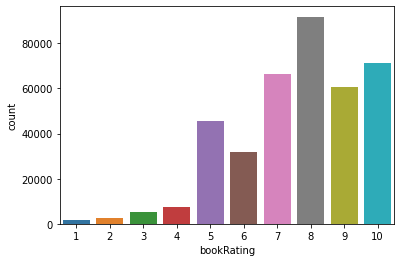

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.countplot(ratings_new.bookRating)

# Q5. Build a User-Based Collaborative Filtering model



1.   Consider users who have rated atleast 100 books
2.   Transform data to surprise format
3.   Assure that only user, book and rating columns are present in the new dataset in surprise format



In [30]:
counts = ratings_new['userID'].value_counts()
ratings_final = ratings_new[ratings_new['userID'].isin(counts[counts >= 100].index)]

In [31]:
ratings_final.shape

(103271, 3)

In [32]:
#2 Transform data to surprise format
from surprise import Dataset,Reader
from surprise.model_selection import cross_validate
from surprise import NormalPredictor


reader = Reader(rating_scale=(1, 10))

In [33]:
data = Dataset.load_from_df(ratings_final, reader)

In [34]:
data

# Q6. Apply SVD for user based filtering


1.   Split the data into train and test
2.   Train model on SVD
3.   Test Accuracy of the model




In [35]:
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.25,random_state=123)

In [36]:
from surprise import SVD
from surprise import accuracy

svd_model = SVD(n_factors=100)
svd_model.fit(trainset)

predictions = svd_model.test(testset)
accuracy.rmse(predictions)

RMSE: 1.5062


1.5062415771013447

In [37]:
predictions = pd.DataFrame(predictions)

In [38]:
predictions.head()

,uid,iid,r_ui,est,details
0,30810,357000077X,9.0,8.673204,{'was_impossible': False}
1,227520,0345387813,7.0,8.303296,{'was_impossible': False}
2,31826,0439207843,10.0,9.736240,{'was_impossible': False}
3,110934,0452273374,9.0,7.821789,{'was_impossible': False}
4,197659,0060192240,9.0,8.114318,{'was_impossible': False}


# Q7. Create a function to generate `n` recommendations for user `x`. (n, x should be parameterized)

In [39]:
def recommandation(x,n):
  recommend = predictions[predictions['uid'] == x][['uid', 'iid', 'r_ui', 'est']].sort_values(by = 'est', ascending = False).head(n)
  return recommend

In [40]:
recommandation(227520, 10)

,uid,iid,r_ui,est
6872,227520,051511779X,10.0,9.019833
5427,227520,0373243286,8.0,8.923645
16223,227520,0425176304,5.0,8.860136
17482,227520,0425191583,10.0,8.839953
20241,227520,0441007813,7.0,8.832660
14605,227520,0515128554,10.0,8.784287
21091,227520,0373484410,8.0,8.762391
25236,227520,0425155188,8.0,8.759877
24522,227520,0345368975,7.0,8.756456
15209,227520,0373484429,7.0,8.728609
